

In this tutorial, you will build out a Multi Layer Perceptron model to try to classify hand written digits using TensorFlow.

Keep in mind that no single lecture (or course!) can cover the vastness that is Deep Learning.

## Get the Data

We will be using the famous MNIST data set of [handwritten digits](http://yann.lecun.com/exdb/mnist/). 

The images which we will be working with are black and white images of size 28 x 28 pixels, or 784 pixels total. Our features will be the pixel values for each pixel. Either the pixel is "white" (blank with a 0), or there is some pixel value. 

We will try to correctly predict what number is written down based solely on the image data in the form of an array. This type of problem (Image Recognition) is a great use case for Deep Learning Methods!

This data is to Deep Learning what the iris data set is to typical machine learning algorithms.  

Let's get the data:

In [20]:
import tensorflow as tf

# Import MINST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


### Data Format

The data is stored in a vector format, although the original data was a 2-dimensional matirx with values representing how much pigment was at a certain location. Let's explore this:

In [21]:
type(mnist)

tensorflow.contrib.learn.python.learn.datasets.base.Datasets

In [22]:
type(mnist.train.images)

numpy.ndarray

In [23]:
#mnist.train.images[0]
mnist.train.images[2].shape

(784,)

In [24]:
sample = mnist.train.images[2].reshape(28,28)

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline

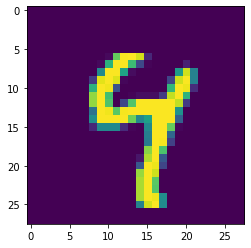

In [26]:
plt.imshow(sample)

## Parameters

We'll need to define 4 parameters, it is really (really) hard to know what good parameter values are on a data set for which you have no experience with, however since MNIST is pretty famous, we have some reasonable values for our data below. The parameters here are:

* Learning Rate - How quickly to adjust the cost function.
* Training Epochs - How many training cycles to go through
* Batch Size - Size of the 'batches' of training data

In [27]:
# Parameters
learning_rate = 0.001
training_epochs = 15
batch_size = 100

### Network Parameters

Here we have parameters which will directly define our Neural Network, these would be adjusted depending on what your data looked like and what kind of a net you would want to build. Basically just some numbers we will eventually use to define some variables later on in our model:

In [28]:
# Network Parameters
n_hidden_1 = 256 # 1st layer number of features
n_hidden_2 = 256 # 2nd layer number of features
n_input = 784 # MNIST data input (img shape: 28*28)
n_classes = 10 # MNIST total classes (0-9 digits)
n_samples = mnist.train.num_examples

###  TensorFlow Graph Input

In [29]:
x = tf.placeholder("float", [None, n_input])
y = tf.placeholder("float", [None, n_classes])

## MultiLayer Model

It is time to create our model, let's review what we want to create here.

First we receive the input data array and then to send it to the first hidden layer. Then the data will begin to have a weight attached to it between layers (remember this is initially a random value) and then sent to a node to undergo an activation function (along with a Bias as mentioned in the lecture). Then it will continue on to the next hidden layer, and so on until the final output layer. In our case, we will just use two hidden layers, the more you use the longer the model will take to run (but it has more of an opportunity to possibly be more accurate on the training data).

Once the transformed "data" has reached the output layer we need to evaluate it. Here we will use a loss function (also called a cost function) to evaluate how far off we are from the desired result. In this case, how many of the classes we got correct. 

Then we will apply an optimization function to minimize the cost (lower the error). This is done by adjusting weight values accordingly across the network. In out example, we will use the [Adam Optimizer](http://arxiv.org/pdf/1412.6980v8.pdf), which keep in mind, relative to other mathematical concepts, is an extremely recent development.

We can adjust how quickly to apply this optimization by changing our earlier learning rate parameter. The lower the rate the higher the possibility for accurate training results, but that comes at the cost of having to wait (physical time wise) for the results. Of course, after a certain point there is no benefit to lower the learning rate.

Now we will create our model, we'll start with 2 hidden layers, which use the [RELU](https://en.wikipedia.org/wiki/Rectifier_(neural_networks) activation function, which is a very simple rectifier function which essentially either returns x or zero. For our final output layer we will use a linear activation with matrix multiplication:

In [30]:
def multilayer_perceptron(x, weights, biases):
    '''
    x : Place Holder for Data Input
    weights: Dictionary of weights
    biases: Dicitionary of biases
    '''
    
    # First Hidden layer with RELU activation
    layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
    layer_1 = tf.nn.relu(layer_1)
    
    # Second Hidden layer with RELU activation
    layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])
    layer_2 = tf.nn.relu(layer_2)
    
    # Last Output layer with linear activation
    out_layer = tf.matmul(layer_2, weights['out']) + biases['out']
    return out_layer

### Weights and Bias

In order for our tensorflow model to work we need to create two dictionaries containing our weight and bias objects for the model. We can use the **tf.variable** object type. This is different from a constant because TensorFlow's Graph Object becomes aware of the states of all the variables. A Variable is a modifiable tensor that lives in TensorFlow's graph of interacting operations. It can be used and even modified by the computation. We will generally have the model parameters be Variables. From the documentation string:

    A variable maintains state in the graph across calls to `run()`. You add a variable to the graph by constructing an instance of the class `Variable`.

    The `Variable()` constructor requires an initial value for the variable, which can be a `Tensor` of any type and shape. The initial value defines the type and shape of the variable. After construction, the type and shape of the variable are fixed. The value can be changed using one of the assign methods.
    
We'll use tf's built-in random_normal method to create the random values for our weights and biases (you could also just pass ones as the initial biases).

In [31]:
weights = {
    'h1': tf.Variable(tf.random_normal([n_input, n_hidden_1])),
    'h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
    'out': tf.Variable(tf.random_normal([n_hidden_2, n_classes]))
}

In [32]:
biases = {
    'b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'b2': tf.Variable(tf.random_normal([n_hidden_2])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

In [33]:
# Construct model
pred = multilayer_perceptron(x, weights, biases)

## Cost and Optimization Functions

We'll use Tensorflow's built-in functions for this part (check out the documentation for a lot more options and discussion on this):

In [34]:
# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(pred, y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

ValueError: Only call `softmax_cross_entropy_with_logits` with named arguments (labels=..., logits=..., ...)

#### Initialization of Variables

Now initialize all those tf.Variable objects we created earlier. This will be the first thing we run when training our model:

In [35]:
# Initializing the variables
init = tf.initialize_all_variables()

Instructions for updating:
Use `tf.global_variables_initializer` instead.


# Training the Model

### next_batch()

Before we get started I want to cover one more convenience function in our mnist data object called next_batch. This returns a tuple in the form (X,y) with an array of the data and a y array indicating the class in the form of a binary array. For example:

In [36]:
Xsamp,ysamp = mnist.train.next_batch(1)

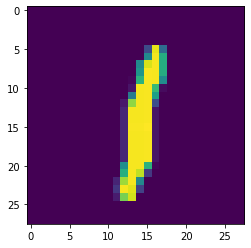

In [38]:
plt.imshow(Xsamp.reshape(28,28))

In [39]:
# Remember indexing starts at zero!
print(ysamp)

[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


## Running the Session
Now it is time to run our session! Pay attention to how we have two loops, the outer loop which runs the epochs, and the inner loop which runs the batches for each epoch of training. Let's breakdown each step!

In [20]:
# Launch the session
sess = tf.InteractiveSession()

# Intialize all the variables
sess.run(init)

# Training Epochs
# Essentially the max amount of loops possible before we stop
# May stop earlier if cost/loss limit was set
for epoch in range(training_epochs):

    # Start with cost = 0.0
    avg_cost = 0.0

    # Convert total number of batches to integer
    total_batch = int(n_samples/batch_size)

    # Loop over all batches
    for i in range(total_batch):

        # Grab the next batch of training data and labels
        batch_x, batch_y = mnist.train.next_batch(batch_size)

        # Feed dictionary for optimization and loss value
        # Returns a tuple, but we only need 'c' the cost
        # So we set an underscore as a "throwaway"
        _, c = sess.run([optimizer, cost], feed_dict={x: batch_x, y: batch_y})

        # Compute average loss
        avg_cost += c / total_batch

    print("Epoch: {} cost={:.4f}".format(epoch+1,avg_cost))

print("Model has completed {} Epochs of Training".format(training_epochs))

Epoch: 1 cost=156.1939
Epoch: 2 cost=38.7113
Epoch: 3 cost=24.6571
Epoch: 4 cost=17.1834
Epoch: 5 cost=12.6043
Epoch: 6 cost=9.4217
Epoch: 7 cost=7.1025
Epoch: 8 cost=5.3346
Epoch: 9 cost=3.9459
Epoch: 10 cost=3.0107
Epoch: 11 cost=2.2067
Epoch: 12 cost=1.6921
Epoch: 13 cost=1.3159
Epoch: 14 cost=0.9436
Epoch: 15 cost=0.7575
Model has completed 15 Epochs of Training


## Model Evaluations

Tensorflow comes with some built-in functions to help evaluate our model, including tf.equal and tf.cast with tf.reduce_mean.

**tf.equal()**

This is essentially just a check of predictions == y_test. In our case since we know the format of the labels is a 1 in an array of zeroes, we can compare argmax() location of that 1. Remember that **y** here is still that placeholder we created at the very beginning, we will perform a series of operations to get a Tensor that we can eventually fill in the test data for with an evaluation method. What we are currently running will still be empty of test data:

In [21]:
# Test model
correct_predictions = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))

In [22]:
print(correct_predictions[0])

Tensor("Squeeze:0", shape=(), dtype=bool)


In order to get a numerical value for our predictions we will need to use tf.cast to cast the Tensor of booleans back into a Tensor of Floating point values in order to take the mean of it.

In [23]:
correct_predictions = tf.cast(correct_predictions, "float")

In [24]:
print(correct_predictions[0])

Tensor("Squeeze_1:0", shape=(), dtype=float32)


Now we use the tf.reduce_mean function in order to grab the mean of the elements across the tensor.

In [25]:
accuracy = tf.reduce_mean(correct_predictions)

In [26]:
type(accuracy)

tensorflow.python.framework.ops.Tensor

This may seem a little strange, but this accuracy is still a Tensor object. Remember that we still need to pass in our actual test data! Now we can call the MNIST test labels and images and evaluate our accuracy!

In [27]:
mnist.test.labels

array([[ 0.,  0.,  0., ...,  1.,  0.,  0.],
       [ 0.,  0.,  1., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [31]:
mnist.test.images

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]], dtype=float32)

The eval() method allows you to directly evaluates this tensor in a `Session` without needing to call tf.sess():mm

In [29]:
print("Accuracy:", accuracy.eval({x: mnist.test.images, y: mnist.test.labels}))

Accuracy: 0.9436


94% not too shabby! But this actually isn't anywhere near as good as it could be. Running for more training epochs with this data (around 20,000) can produce accuracy around 99%. But we won't do that here because that will take a very long time to run!

# Great Job!

### Extra Credit: See what happens if you try to make this model again with more layers!